# Linear Regression Model for Ozone Level in Denver, Colorado

Most of us probably remember learning about the protection that the ozone layer in the upper atmosphere lends us. However, ground level ozone has well documented negative effects. Those with Athsma are particularly at risk to it [[1]](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics). Denver has one of the worst levels of ground level ozone in the united states [[2]](https://www.denverpost.com/2021/06/16/denver-fortcollins-worst-cities-air-pollution/). It is well known that ozone is greatly affected by pollutants emitted by cars, power plants, refineries, etc. in the presence of sunlight [[3]](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics#:~:text=This%20happens%20when%20pollutants%20emitted,high%20levels%20during%20colder%20months.). 

**Goal**: To develop a reasonaly accurate linear regression model to predict the amount of ozone in the air. 

**Results**: Using historical weather data paired with EPA data on ozone pollutant a model with R^2 of 0.55 and a mean average error of <.01 ppm. Lasso regression is also tested, but yields no 

[Ozone Data](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw)

[Worst Ranking Ozone Levels](https://www.lung.org/research/sota/city-rankings/most-polluted-cities)

[Historical Weather Data](https://visualcrossing.com/)

[Weather Data Documentation](https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/)

[Effect of Weekends](https://www.tandfonline.com/doi/full/10.1080/10962247.2012.749312#:~:text=In%20simple%20terms%2C%20the%20ozone,NOx\)%2C%20on%20weekends.)

# Utilities, Constants

In [1]:
def calculate_percent_missing(in_df):
    # function which returns a dataframe indicating what percent of a column is missing
    percent_missing = in_df.isnull().sum() * 100 / len(in_df)
    return pd.DataFrame({'percent_missing': percent_missing})

TEST_FRACTION = .25 #percentage of the test size
CV = 7 #cross validations to do in grid search
N_JOBS = 7 #number of cores
RAND_STATE = 0 #will be doing multiple train-test-splits, and want to keep everything random, but do the same train-test-splits

In [324]:
def get_poly_scaled(df, numerical_cols, cat_cols, target_col, n_deg):
    """ Takes in a data a data set, the numerical columns you are interested in, and categorical columns and degree and returns a 
    the scaled numerical dataset with with polynomial features of degree n_deg, the categorical columns, and the target columns all properly indexed
    Args:
    in_df: dataframe
    numerical_cols: numerical column names, list
    cat_cols: categorical column names, list
    target: target name, string
    n_deg: integer, the degree
    """
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #scaling the parameters
    ss = StandardScaler()
    poly = PolynomialFeatures(n_deg)
    in_df = df.reset_index()
    #Ensure the index is set from 0 to n-1, since poly.fit_transform will return a dataframe and we'll have unmatched indices if we do not do this
    #in_df.reset_index(inplace=True)
    
    # Categorize the types of features and target
    df_num = in_df[numerical_cols]
    df_cat = in_df[cat_cols]
    y = in_df[target_col]
    #Transform
    use_poly = poly.fit_transform(df_num)
    df_poly = pd.DataFrame(use_poly)
    
    # Set column names
    df_poly.columns = poly.get_feature_names(df_num.columns)
    df_scaled_poly = pd.DataFrame(ss.fit_transform(df_poly), index=df_poly.index, columns=df_poly.columns)
    return (df_scaled_poly, df_cat, y)

def get_mae(reg, X, y):
    """ returns the mean average error of the regressor reg on X """
    y_pred = reg.predict(X)
    abs_err = np.abs(y_pred - y)
    return abs_err.mean()

def get_rmse(reg, X, y):
    """ returns the root mean square error of the regressor reg on X """
    y_pred = reg.predict(X)
    sqr_err = np.power(y_pred - y, 2)
    mse = np.mean(sqr_err)
    return np.sqrt(mse)

def print_errors(reg, X, y):
    """ prints mae and rmse """
    print("MAE: {:.4f} \nRMSE: {:.4f}".format(get_mae(reg, X, y), get_rmse(reg, X, y)))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('data/ozone_2019.csv')

/home/jcummings/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_col_weather = pd.read_csv('data/denver_weather_2019_real.csv')

# 1. Exploring the D


## Parameters and useful functions for analysis

In [4]:
# Lower case columns, check out the data. Nothing super surprising here
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.describe()

,state code,county code,site num,parameter code,poc,latitude,longitude,sample measurement,mdl,uncertainty,method code
count,9.142786e+06,9.142786e+06,9.142786e+06,9142786.0,9.142786e+06,9.142786e+06,9.142786e+06,9.142786e+06,9.142786e+06,0.0,9.142786e+06
mean,2.668803e+01,7.627163e+01,1.344786e+03,44201.0,1.084851e+00,3.758337e+01,-9.520775e+01,3.078728e-02,1.397212e-01,NaN,7.220774e+01
std,1.684961e+01,8.080285e+01,2.670646e+03,0.0,3.483333e-01,4.926934e+00,1.619993e+01,1.481152e-02,8.220645e-01,NaN,4.150573e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,44201.0,1.000000e+00,1.821604e+01,-1.580886e+02,-4.000000e-03,6.000000e-04,NaN,1.900000e+01
25%,1.000000e+01,2.300000e+01,6.000000e+00,44201.0,1.000000e+00,3.406957e+01,-1.101827e+02,2.100000e-02,5.000000e-03,NaN,4.700000e+01
50%,2.600000e+01,5.900000e+01,2.500000e+01,44201.0,1.000000e+00,3.835655e+01,-9.121356e+01,3.100000e-02,5.000000e-03,NaN,8.700000e+01
75%,4.200000e+01,1.030000e+02,1.015000e+03,44201.0,1.000000e+00,4.095960e+01,-8.213125e+01,4.100000e-02,5.000000e-03,NaN,8.700000e+01
max,8.000000e+01,8.000000e+02,9.997000e+03,44201.0,6.000000e+00,6.484569e+01,-6.612653e+01,1.600000e-01,8.000000e+00,NaN,9.010000e+02


In [5]:
df.columns

Index(['state code', 'county code', 'site num', 'parameter code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter name', 'date local',
       'time local', 'date gmt', 'time gmt', 'sample measurement',
       'units of measure', 'mdl', 'uncertainty', 'qualifier', 'method type',
       'method code', 'method name', 'state name', 'county name',
       'date of last change'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9142786 entries, 0 to 9142785
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   state code           int64  
 1   county code          int64  
 2   site num             int64  
 3   parameter code       int64  
 4   poc                  int64  
 5   latitude             float64
 6   longitude            float64
 7   datum                object 
 8   parameter name       object 
 9   date local           object 
 10  time local           object 
 11  date gmt             object 
 12  time gmt             object 
 13  sample measurement   float64
 14  units of measure     object 
 15  mdl                  float64
 16  uncertainty          float64
 17  qualifier            object 
 18  method type          object 
 19  method code          int64  
 20  method name          object 
 21  state name           object 
 22  county name          object 
 23  date of last change  object 
dty

In [7]:
# Getting colorado's data
df_col_oz = df.loc[(df['county name']=='Denver') & (df['state name']=='Colorado')]

<AxesSubplot:xlabel='sample measurement', ylabel='Count'>

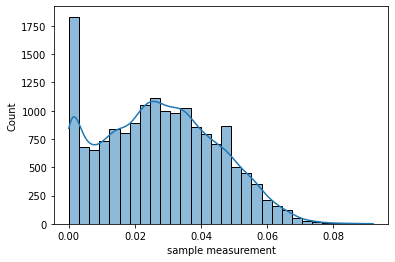

In [8]:
# Taking a peek at the histogram Spike in the count at 0
sns.histplot(df_col_oz['sample measurement'], kde = True, bins=30)

In [9]:
df_col_oz.head()

,state code,county code,site num,parameter code,poc,latitude,longitude,datum,parameter name,date local,...,units of measure,mdl,uncertainty,qualifier,method type,method code,method name,state name,county name,date of last change
1999057,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999058,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999059,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999060,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15
1999061,8,31,2,44201,6,39.751184,-104.987625,WGS84,Ozone,2019-01-01,...,Parts per million,0.005,NaN,NaN,FEM,87,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Colorado,Denver,2019-03-15


In [10]:
df_col_oz['latitude'].unique()

array([39.751184, 39.77949 ])

In [11]:
len(df_col_oz.loc[df_col_oz['latitude']==39.77949, 'date local'].unique())

342

In [12]:
len(df_col_oz.loc[df_col_oz['latitude']==39.751184, 'date local'].unique())

361

In [13]:
df_col_oz = df_col_oz[df_col_oz['latitude']==39.751184]

In [14]:
df_col_oz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8639 entries, 1999057 to 2007695
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state code           8639 non-null   int64  
 1   county code          8639 non-null   int64  
 2   site num             8639 non-null   int64  
 3   parameter code       8639 non-null   int64  
 4   poc                  8639 non-null   int64  
 5   latitude             8639 non-null   float64
 6   longitude            8639 non-null   float64
 7   datum                8639 non-null   object 
 8   parameter name       8639 non-null   object 
 9   date local           8639 non-null   object 
 10  time local           8639 non-null   object 
 11  date gmt             8639 non-null   object 
 12  time gmt             8639 non-null   object 
 13  sample measurement   8639 non-null   float64
 14  units of measure     8639 non-null   object 
 15  mdl                  8639 non

In [15]:
df_col_oz['mdl'].unique()

array([0.005])

In [16]:
df_col_oz['qualifier'].unique()

array([nan], dtype=object)

In [17]:
useful_cols = ['date local', 'time local', 'sample measurement']
df_col_oz = df_col_oz[useful_cols]

In [18]:
df_col_oz.head()

,date local,time local,sample measurement
1999057,2019-01-01,00:00,0.013
1999058,2019-01-01,01:00,0.016
1999059,2019-01-01,02:00,0.016
1999060,2019-01-01,03:00,0.021
1999061,2019-01-01,04:00,0.023


In [19]:
df_col_oz.shape

(8639, 3)

In [20]:
pd.to_datetime(df_col_weather['datetime'])

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime, Length: 17544, dtype: datetime64[ns]

In [21]:
df_col_weather['datetime']

0        2018-01-01T00:00:00
1        2018-01-01T01:00:00
2        2018-01-01T02:00:00
3        2018-01-01T03:00:00
4        2018-01-01T04:00:00
                ...         
17539    2020-01-01T19:00:00
17540    2020-01-01T20:00:00
17541    2020-01-01T21:00:00
17542    2020-01-01T22:00:00
17543    2020-01-01T23:00:00
Name: datetime, Length: 17544, dtype: object

In [22]:
df_col_weather['datetime_dt'] = pd.to_datetime(df_col_weather['datetime'])

In [23]:
df_col_weather['datetime_dt']

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime_dt, Length: 17544, dtype: datetime64[ns]

In [24]:
df_col_oz['datetime'] = df_col_oz['date local'] + ' ' + df_col_oz['time local'] + ':00'
df_col_oz

,date local,time local,sample measurement,datetime
1999057,2019-01-01,00:00,0.013,2019-01-01 00:00:00
1999058,2019-01-01,01:00,0.016,2019-01-01 01:00:00
1999059,2019-01-01,02:00,0.016,2019-01-01 02:00:00
1999060,2019-01-01,03:00,0.021,2019-01-01 03:00:00
1999061,2019-01-01,04:00,0.023,2019-01-01 04:00:00
...,...,...,...,...
2007691,2019-12-31,19:00,0.002,2019-12-31 19:00:00
2007692,2019-12-31,20:00,0.003,2019-12-31 20:00:00
2007693,2019-12-31,21:00,0.011,2019-12-31 21:00:00
2007694,2019-12-31,22:00,0.022,2019-12-31 22:00:00


In [25]:
df_col_oz['datetime'] = pd.to_datetime(df_col_oz['datetime'])

In [26]:
df_col_oz['datetime']

1999057   2019-01-01 00:00:00
1999058   2019-01-01 01:00:00
1999059   2019-01-01 02:00:00
1999060   2019-01-01 03:00:00
1999061   2019-01-01 04:00:00
                  ...        
2007691   2019-12-31 19:00:00
2007692   2019-12-31 20:00:00
2007693   2019-12-31 21:00:00
2007694   2019-12-31 22:00:00
2007695   2019-12-31 23:00:00
Name: datetime, Length: 8639, dtype: datetime64[ns]

In [27]:
df_col_weather['datetime_dt']

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
17539   2020-01-01 19:00:00
17540   2020-01-01 20:00:00
17541   2020-01-01 21:00:00
17542   2020-01-01 22:00:00
17543   2020-01-01 23:00:00
Name: datetime_dt, Length: 17544, dtype: datetime64[ns]

In [28]:
df_col_oz.head()

,date local,time local,sample measurement,datetime
1999057,2019-01-01,00:00,0.013,2019-01-01 00:00:00
1999058,2019-01-01,01:00,0.016,2019-01-01 01:00:00
1999059,2019-01-01,02:00,0.016,2019-01-01 02:00:00
1999060,2019-01-01,03:00,0.021,2019-01-01 03:00:00
1999061,2019-01-01,04:00,0.023,2019-01-01 04:00:00


In [29]:
df_col = df_col_oz.merge(df_col_weather, left_on='datetime', right_on='datetime_dt', suffixes=('_oz', '_weather'), how='left')

In [30]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8640 entries, 0 to 8639
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date local          8640 non-null   object        
 1   time local          8640 non-null   object        
 2   sample measurement  8640 non-null   float64       
 3   datetime_oz         8640 non-null   datetime64[ns]
 4   name                8639 non-null   object        
 5   datetime_weather    8639 non-null   object        
 6   temp                8639 non-null   float64       
 7   feelslike           8639 non-null   float64       
 8   dew                 8639 non-null   float64       
 9   humidity            8639 non-null   float64       
 10  precip              8581 non-null   float64       
 11  precipprob          0 non-null      float64       
 12  preciptype          0 non-null      float64       
 13  snow                8639 non-null   float64     

In [31]:
df_col['day_of_week'] = df_col['datetime_dt'].dt.dayofweek

In [32]:
df_col['type of day'] = 'weekday'

In [33]:
weekend_mask = ((df_col['day_of_week']==5) | (df_col['day_of_week']==6))
df_col.loc[weekend_mask, 'type of day'] = 'weekend'

In [34]:
df_col.groupby('type of day').agg({'sample measurement': 'mean'})

,sample measurement
type of day,
weekday,0.025862
weekend,0.030961


In [35]:
df_col.groupby('conditions').agg({'sample measurement': 'mean'})

,sample measurement
conditions,
Clear,0.018760
Overcast,0.018964
Partially cloudy,0.029132
"Rain, Overcast",0.017875
"Rain, Partially cloudy",0.034946
"Snow, Overcast",0.017460
"Snow, Partially cloudy",0.018608


In [36]:
df_col['hour'] = df_col['datetime_dt'].dt.hour
df_col

,date local,time local,sample measurement,datetime_oz,name,datetime_weather,temp,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,conditions,icon,stations,datetime_dt,day_of_week,type of day,hour
0,2019-01-01,00:00,0.013,2019-01-01 00:00:00,"39.75, -104.987625",2019-01-01T00:00:00,0.9,-9.7,-1.6,88.81,...,NaN,0.0,NaN,Partially cloudy,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 00:00:00,1.0,weekday,0.0
1,2019-01-01,01:00,0.016,2019-01-01 01:00:00,"39.75, -104.987625",2019-01-01T01:00:00,0.1,-10.4,-3.1,86.21,...,NaN,0.0,NaN,Overcast,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 01:00:00,1.0,weekday,1.0
2,2019-01-01,02:00,0.016,2019-01-01 02:00:00,"39.75, -104.987625",2019-01-01T02:00:00,0.2,-10.9,-2.9,86.25,...,NaN,0.0,NaN,Overcast,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 02:00:00,1.0,weekday,2.0
3,2019-01-01,03:00,0.021,2019-01-01 03:00:00,"39.75, -104.987625",2019-01-01T03:00:00,0.5,-12.5,-2.7,85.95,...,NaN,0.0,NaN,Overcast,snow,"KBKF,72469523036,KAPA,72565003017,72466693067",2019-01-01 03:00:00,1.0,weekday,3.0
4,2019-01-01,04:00,0.023,2019-01-01 04:00:00,"39.75, -104.987625",2019-01-01T04:00:00,0.4,-13.3,-3.0,85.06,...,NaN,0.0,NaN,Partially cloudy,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 04:00:00,1.0,weekday,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2019-12-31,19:00,0.002,2019-12-31 19:00:00,"39.75, -104.987625",2019-12-31T19:00:00,31.1,23.4,8.2,37.63,...,NaN,0.0,NaN,Clear,clear-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-12-31 19:00:00,1.0,weekday,19.0
8636,2019-12-31,20:00,0.003,2019-12-31 20:00:00,"39.75, -104.987625",2019-12-31T20:00:00,30.3,24.4,7.2,37.17,...,NaN,0.0,NaN,Clear,clear-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-12-31 20:00:00,1.0,weekday,20.0
8637,2019-12-31,21:00,0.011,2019-12-31 21:00:00,"39.75, -104.987625",2019-12-31T21:00:00,31.8,23.9,5.3,32.11,...,NaN,0.0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-12-31 21:00:00,1.0,weekday,21.0
8638,2019-12-31,22:00,0.022,2019-12-31 22:00:00,"39.75, -104.987625",2019-12-31T22:00:00,31.5,23.2,6.5,34.29,...,NaN,0.0,NaN,Partially cloudy,partly-cloudy-night,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-12-31 22:00:00,1.0,weekday,22.0


In [37]:
df_col['month'] = df_col['datetime_dt'].dt.month
df_col.groupby('month').agg({'sample measurement': 'mean'})

,sample measurement
month,
1.0,0.015444
2.0,0.016525
3.0,0.026470
4.0,0.032462
5.0,0.031878
6.0,0.039393
7.0,0.039472
8.0,0.040916
9.0,0.032408


In [38]:
# The month seems to be important, let's parameterize it cyclicly
df_col['month_x'] = np.cos(np.pi/6.0*df_col['month'])
df_col['month_y'] = np.sin(np.pi/6.0*df_col['month'])

In [39]:
#

In [40]:
np.pi

3.141592653589793

<AxesSubplot:xlabel='cloudcover', ylabel='Count'>

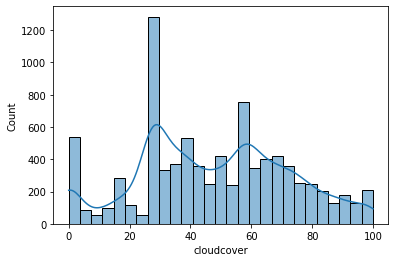

In [41]:
sns.histplot(df_col['cloudcover'], kde=True)

In [42]:
df_col['uvindex'].unique()

array([ 0., nan])

In [43]:
df_col['conditions'].unique()

array(['Partially cloudy', 'Overcast', 'Clear', 'Snow, Overcast',
       'Snow, Partially cloudy', 'Rain, Partially cloudy',
       'Rain, Overcast', nan], dtype=object)

In [44]:
df_col.groupby('conditions').agg({'sample measurement': 'mean'})

,sample measurement
conditions,
Clear,0.018760
Overcast,0.018964
Partially cloudy,0.029132
"Rain, Overcast",0.017875
"Rain, Partially cloudy",0.034946
"Snow, Overcast",0.017460
"Snow, Partially cloudy",0.018608


In [45]:
df_col['dew'].dtype=='float64'

True

In [46]:
# Many observations in each month with a high ozone level.
THRESH = .04
ozone_high_mask = df['sample measurement']>THRESH
df_col['high ozone']=0.0
df_col.loc[ozone_high_mask, 'high ozone']=1.0
df_col.groupby('month').agg({'high ozone': sum})

,high ozone
month,
1.0,267.0
2.0,273.0
3.0,224.0
4.0,150.0
5.0,147.0
6.0,130.0
7.0,150.0
8.0,57.0
9.0,258.0


/home/jcummings/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


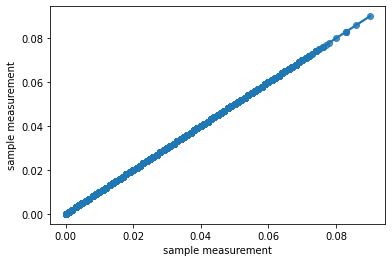

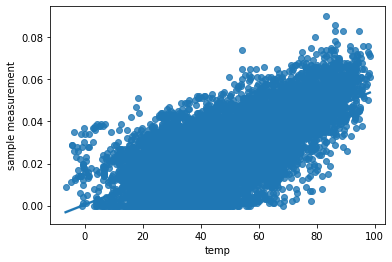

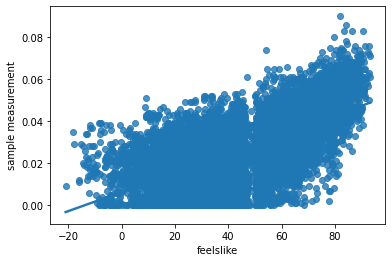

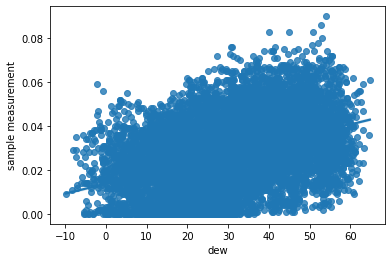

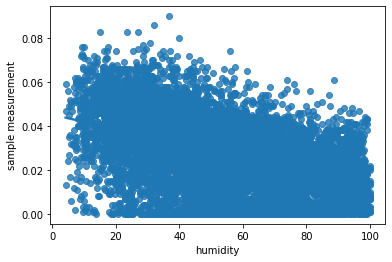

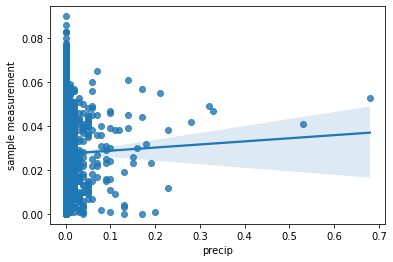

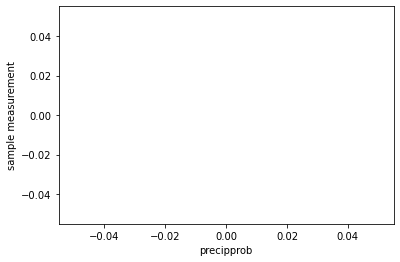

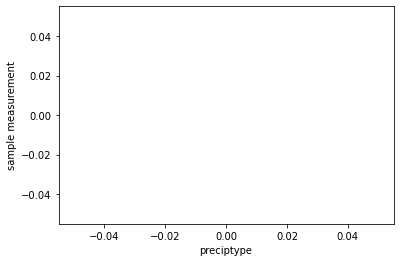

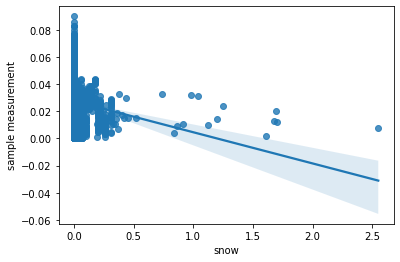

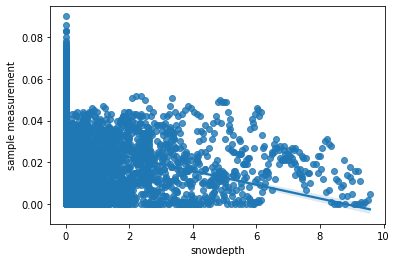

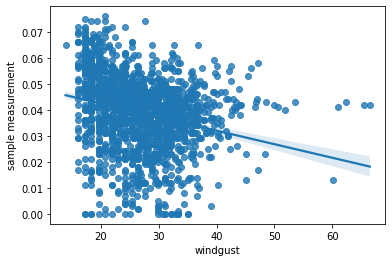

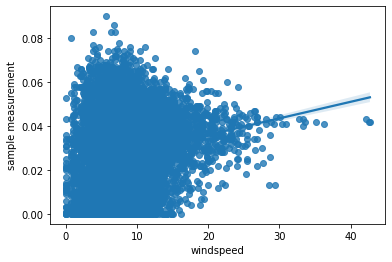

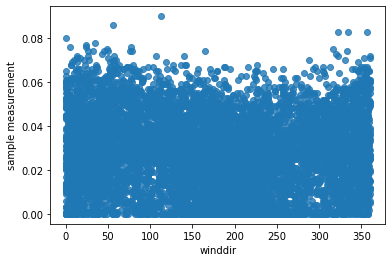

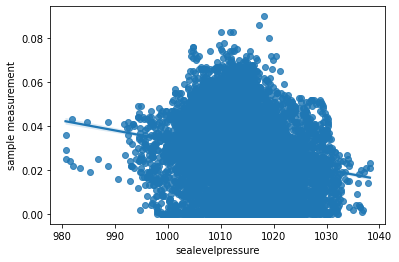

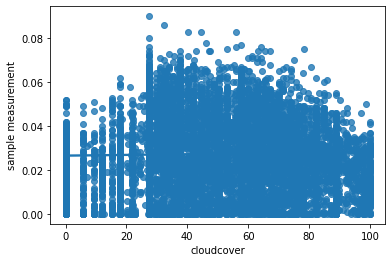

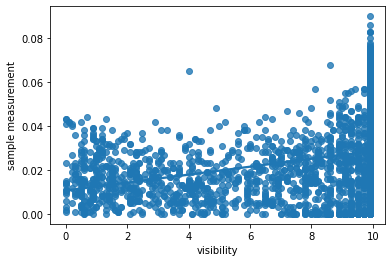

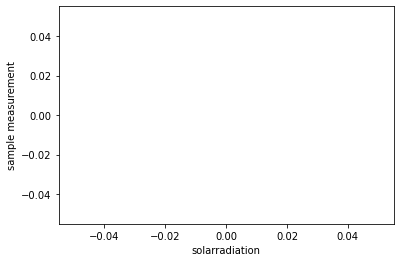

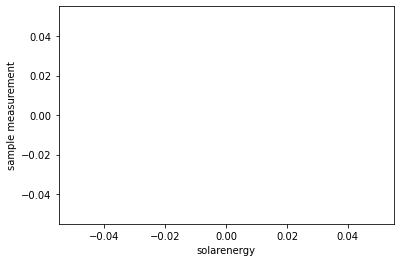

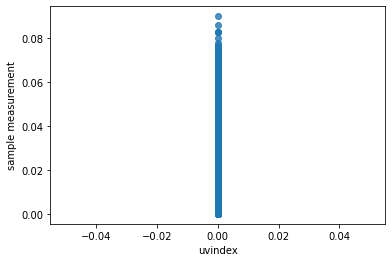

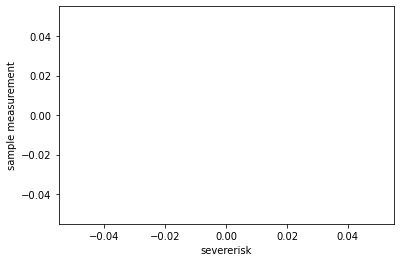

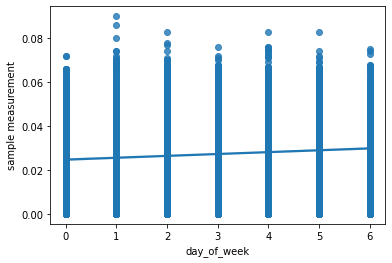

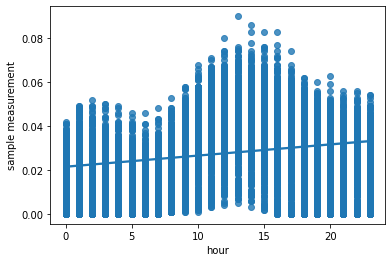

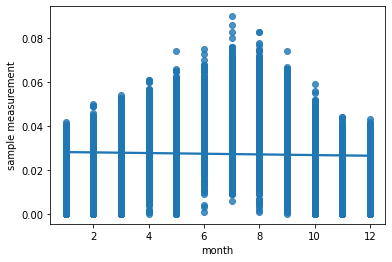

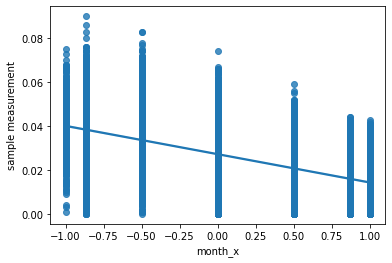

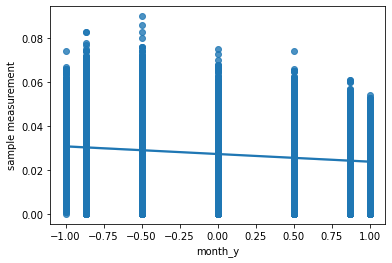

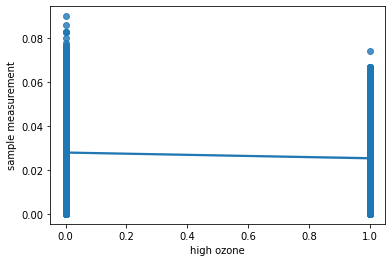

In [47]:
numer_cols = [i for i in df_col.columns if df_col[i].dtype=='float64']
for i in numer_cols:
    plt.figure(i)
    ax = sns.regplot(x=i, y='sample measurement', data = df_col)

In [48]:
calculate_percent_missing(df_col)

,percent_missing
date local,0.000000
time local,0.000000
sample measurement,0.000000
datetime_oz,0.000000
name,0.011574
datetime_weather,0.011574
temp,0.011574
feelslike,0.011574
dew,0.011574
humidity,0.011574


In [258]:
df_col.head()

,date local,time local,sample measurement,datetime_oz,name,datetime_weather,temp,feelslike,dew,humidity,...,icon,stations,datetime_dt,day_of_week,type of day,hour,month,month_x,month_y,high ozone
0,2019-01-01,00:00,0.013,2019-01-01 00:00:00,"39.75, -104.987625",2019-01-01T00:00:00,0.9,-9.7,-1.6,88.81,...,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 00:00:00,1.0,weekday,0.0,1.0,0.866025,0.5,0.0
1,2019-01-01,01:00,0.016,2019-01-01 01:00:00,"39.75, -104.987625",2019-01-01T01:00:00,0.1,-10.4,-3.1,86.21,...,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 01:00:00,1.0,weekday,1.0,1.0,0.866025,0.5,0.0
2,2019-01-01,02:00,0.016,2019-01-01 02:00:00,"39.75, -104.987625",2019-01-01T02:00:00,0.2,-10.9,-2.9,86.25,...,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 02:00:00,1.0,weekday,2.0,1.0,0.866025,0.5,0.0
3,2019-01-01,03:00,0.021,2019-01-01 03:00:00,"39.75, -104.987625",2019-01-01T03:00:00,0.5,-12.5,-2.7,85.95,...,snow,"KBKF,72469523036,KAPA,72565003017,72466693067",2019-01-01 03:00:00,1.0,weekday,3.0,1.0,0.866025,0.5,0.0
4,2019-01-01,04:00,0.023,2019-01-01 04:00:00,"39.75, -104.987625",2019-01-01T04:00:00,0.4,-13.3,-3.0,85.06,...,snow,"KBKF,KDEN,72469523036,KAPA,72565003017,7246669...",2019-01-01 04:00:00,1.0,weekday,4.0,1.0,0.866025,0.5,0.0


In [259]:
use_cols_numerical=['temp', 'humidity', 'windspeed', 'month_x', 'month_y', 'sealevelpressure']
use_cols_cat = ['type of day']
target='sample measurement'
df_col_useful = df_col[use_cols_numerical + use_cols_cat + [target]]

In [260]:
calculate_percent_missing(df_col_useful)

,percent_missing
temp,0.011574
humidity,0.011574
windspeed,0.011574
month_x,0.011574
month_y,0.011574
sealevelpressure,0.011574
type of day,0.000000
sample measurement,0.000000


In [261]:
df_col_useful = df_col_useful.dropna()
df_use_num = df_col_useful[use_cols_numerical]
df_use_cat = df_col_useful[use_cols_cat]
y = df_col_useful[target]

In [262]:
df_col_useful = df_col_useful.dropna()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler #scaling the parameters
ss = StandardScaler()
rs = RobustScaler()
df_scaled = pd.DataFrame(ss.fit_transform(df_use_num), index=df_use_num.index, columns=use_cols_numerical)
#pd.pivot_table(df_scaled, index=['diabetes'],  values = df_scaled.columns, aggfunc = np.mean)

In [263]:
df_cat_encoded = pd.get_dummies(df_use_cat, drop_first = True)
df_cat_encoded

,type of day_weekend
0,0
1,0
2,0
3,0
4,0
...,...
8635,0
8636,0
8637,0
8638,0


In [264]:
from sklearn.model_selection import train_test_split
X = pd.concat([df_scaled, df_cat_encoded], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRACTION, random_state = RAND_STATE)

In [265]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)

0.5629269654530034

In [268]:
print(get_mae(reg, X_test, y_test), get_rmse(reg, X_test, y_test))

0.009257015999474883 0.011324711743928342


<AxesSubplot:ylabel='Count'>

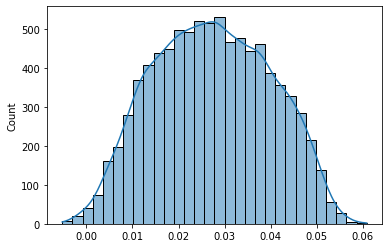

In [269]:
sns.histplot(reg.predict(X), kde = True, bins=30)

# Polynomial Regression

In [311]:
use_cols_numerical=['temp', 'humidity', 'windspeed', 'month_x', 'month_y', 'sealevelpressure']
use_cols_cat = ['type of day']
target='sample measurement'
df_col_useful = df_col[use_cols_numerical + use_cols_cat + [target]]
df_col_useful.dropna(inplace=True)

/home/jcummings/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [312]:
N_DEG = 7
df_scaled_p, df_cat_p, y = get_poly_scaled(df_col_useful, use_cols_numerical, use_cols_cat, target, N_DEG)

In [313]:
df_cat_encoded = pd.get_dummies(df_cat_p, drop_first = True)
df_cat_encoded 

,type of day_weekend
0,0
1,0
2,0
3,0
4,0
...,...
8634,0
8635,0
8636,0
8637,0


In [314]:
from sklearn.model_selection import train_test_split
X = pd.concat([df_scaled_p, df_cat_encoded], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRACTION, random_state = RAND_STATE)

In [315]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.7937087241511976

In [316]:
reg.score(X_test, y_test)

0.44207477836986775

In [317]:
#print(get_mae(reg, X_test, y_test), get_rmse(reg, X_test, y_test))
print_errors(reg, X_test, y_test)

MAE: 0.0080 
RMSE: 0.0128


<AxesSubplot:ylabel='Count'>

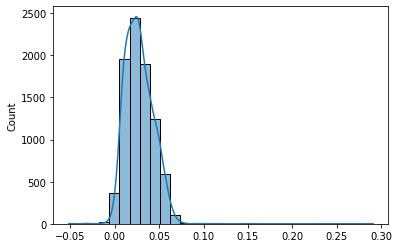

In [318]:
sns.histplot(reg.predict(X), kde = True, bins=30)

In [319]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
alpha = np.linspace(.001, 1, 5)
ridge_params = {'alpha':alpha}
reg_ridge = linear_model.Ridge(alpha=10)
grid_ridge = GridSearchCV(reg_ridge, param_grid=ridge_params, cv=CV, n_jobs=N_JOBS, verbose=2)
grid_ridge.fit(X_train, y_train)

Fitting 7 folds for each of 5 candidates, totalling 35 fits


GridSearchCV(cv=7, estimator=Ridge(alpha=10), n_jobs=7,
             param_grid={'alpha': array([0.001  , 0.25075, 0.5005 , 0.75025, 1.     ])},
             verbose=2)

In [320]:
grid_ridge.score(X_test, y_test)

0.6701990995986791

In [321]:
print('Best Params: {}, \n Best score: {:.2f}'.format(grid_ridge.best_params_, grid_ridge.best_score_))

Best Params: {'alpha': 0.25075}, 
 Best score: 0.67


In [322]:
print_errors(grid_ridge, X_test, y_test)

MAE: 0.0077 
RMSE: 0.0098


<AxesSubplot:ylabel='Count'>

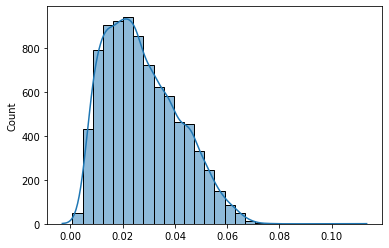

In [323]:
sns.histplot(grid_ridge.predict(X), kde = True, bins=30)